In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

Implement the loss function in ```yolo_loss.py```. You can use ```yolo_loss_debug_tool.ipynb``` to help you debug.

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effictively.

In [7]:
load_network_path = './45_detector.pth'
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from ./45_detector.pth


In [5]:
learning_rate = 0.001
#
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [6]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [72]:
file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'


train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

/newtests/
Initializing dataset
Loaded 5011 train images


In [73]:
file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'
print(file_root_test)
test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

VOCdevkit_2007/VOC2007test/JPEGImages/
Initializing dataset
Loaded 4950 test images


## Train detector

In [ ]:
num_epochs = 65

best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')
    if(epoch % 5 == 0):
        
        path=str(epoch)+'_detector.pth'
        print("saving",path)
        torch.save(net.state_dict(),path)
    




Starting epoch 1 / 65
Learning Rate for this epoch: 0.001
Epoch [1/65], Iter [5/209] Loss: 3.2495, average_loss: 3.0255
Epoch [1/65], Iter [10/209] Loss: 1.8367, average_loss: 2.6836
Epoch [1/65], Iter [15/209] Loss: 2.3960, average_loss: 2.6684
Epoch [1/65], Iter [20/209] Loss: 1.6961, average_loss: 2.6860
Epoch [1/65], Iter [25/209] Loss: 2.3056, average_loss: 2.6820
Epoch [1/65], Iter [30/209] Loss: 1.5845, average_loss: 2.6226
Epoch [1/65], Iter [35/209] Loss: 2.3538, average_loss: 2.6023
Epoch [1/65], Iter [40/209] Loss: 1.8905, average_loss: 2.5819
Epoch [1/65], Iter [45/209] Loss: 2.1424, average_loss: 2.5727
Epoch [1/65], Iter [50/209] Loss: 2.0499, average_loss: 2.5540
Epoch [1/65], Iter [55/209] Loss: 3.7583, average_loss: 2.5758
Epoch [1/65], Iter [60/209] Loss: 2.3395, average_loss: 2.5590
Epoch [1/65], Iter [65/209] Loss: 3.1787, average_loss: 2.5607
Epoch [1/65], Iter [70/209] Loss: 3.0241, average_loss: 2.5843
Epoch [1/65], Iter [75/209] Loss: 2.5456, average_loss: 2.5

Epoch [4/65], Iter [10/209] Loss: 2.4029, average_loss: 2.3273
Epoch [4/65], Iter [15/209] Loss: 2.3143, average_loss: 2.3709
Epoch [4/65], Iter [20/209] Loss: 1.8128, average_loss: 2.3608
Epoch [4/65], Iter [25/209] Loss: 1.9807, average_loss: 2.3726
Epoch [4/65], Iter [30/209] Loss: 1.6439, average_loss: 2.3665
Epoch [4/65], Iter [35/209] Loss: 2.4759, average_loss: 2.3538
Epoch [4/65], Iter [40/209] Loss: 3.5743, average_loss: 2.4013
Epoch [4/65], Iter [45/209] Loss: 2.9130, average_loss: 2.4156
Epoch [4/65], Iter [50/209] Loss: 2.0120, average_loss: 2.4133
Epoch [4/65], Iter [55/209] Loss: 1.9447, average_loss: 2.3952
Epoch [4/65], Iter [60/209] Loss: 2.2969, average_loss: 2.3993
Epoch [4/65], Iter [65/209] Loss: 2.5573, average_loss: 2.4200
Epoch [4/65], Iter [70/209] Loss: 2.2350, average_loss: 2.4127
Epoch [4/65], Iter [75/209] Loss: 3.2448, average_loss: 2.4181
Epoch [4/65], Iter [80/209] Loss: 2.1002, average_loss: 2.3973
Epoch [4/65], Iter [85/209] Loss: 2.5634, average_loss:

Epoch [7/65], Iter [20/209] Loss: 1.6190, average_loss: 2.3119
Epoch [7/65], Iter [25/209] Loss: 2.8940, average_loss: 2.3055
Epoch [7/65], Iter [30/209] Loss: 1.9638, average_loss: 2.2251
Epoch [7/65], Iter [35/209] Loss: 2.1282, average_loss: 2.2504
Epoch [7/65], Iter [40/209] Loss: 2.3823, average_loss: 2.2167
Epoch [7/65], Iter [45/209] Loss: 2.9462, average_loss: 2.2631
Epoch [7/65], Iter [50/209] Loss: 2.0691, average_loss: 2.2512
Epoch [7/65], Iter [55/209] Loss: 1.5023, average_loss: 2.2228
Epoch [7/65], Iter [60/209] Loss: 2.1599, average_loss: 2.2150
Epoch [7/65], Iter [65/209] Loss: 3.3061, average_loss: 2.2259
Epoch [7/65], Iter [70/209] Loss: 1.9271, average_loss: 2.2167
Epoch [7/65], Iter [75/209] Loss: 1.6833, average_loss: 2.2115
Epoch [7/65], Iter [80/209] Loss: 2.2928, average_loss: 2.2078
Epoch [7/65], Iter [85/209] Loss: 2.3423, average_loss: 2.2164
Epoch [7/65], Iter [90/209] Loss: 2.0254, average_loss: 2.2126
Epoch [7/65], Iter [95/209] Loss: 2.7233, average_loss:

Epoch [10/65], Iter [35/209] Loss: 1.7001, average_loss: 2.0338
Epoch [10/65], Iter [40/209] Loss: 1.4260, average_loss: 2.0204
Epoch [10/65], Iter [45/209] Loss: 1.7623, average_loss: 2.0267
Epoch [10/65], Iter [50/209] Loss: 2.7141, average_loss: 2.0534
Epoch [10/65], Iter [55/209] Loss: 2.7482, average_loss: 2.0734
Epoch [10/65], Iter [60/209] Loss: 2.1386, average_loss: 2.0665
Epoch [10/65], Iter [65/209] Loss: 2.1362, average_loss: 2.0738
Epoch [10/65], Iter [70/209] Loss: 2.4052, average_loss: 2.0868
Epoch [10/65], Iter [75/209] Loss: 2.0031, average_loss: 2.0825
Epoch [10/65], Iter [80/209] Loss: 3.4115, average_loss: 2.0958
Epoch [10/65], Iter [85/209] Loss: 1.7133, average_loss: 2.0834
Epoch [10/65], Iter [90/209] Loss: 2.5942, average_loss: 2.0883
Epoch [10/65], Iter [95/209] Loss: 1.8440, average_loss: 2.0935
Epoch [10/65], Iter [100/209] Loss: 1.7692, average_loss: 2.0977
Epoch [10/65], Iter [105/209] Loss: 1.7791, average_loss: 2.0957
Epoch [10/65], Iter [110/209] Loss: 2.

Epoch [13/65], Iter [35/209] Loss: 1.5914, average_loss: 2.0327
Epoch [13/65], Iter [40/209] Loss: 1.9946, average_loss: 2.0141
Epoch [13/65], Iter [45/209] Loss: 1.8708, average_loss: 2.0177
Epoch [13/65], Iter [50/209] Loss: 2.4656, average_loss: 2.0625
Epoch [13/65], Iter [55/209] Loss: 1.5498, average_loss: 2.0394
Epoch [13/65], Iter [60/209] Loss: 2.4279, average_loss: 2.0388
Epoch [13/65], Iter [65/209] Loss: 2.7368, average_loss: 2.0569
Epoch [13/65], Iter [70/209] Loss: 1.6316, average_loss: 2.0462
Epoch [13/65], Iter [75/209] Loss: 2.1443, average_loss: 2.0484
Epoch [13/65], Iter [80/209] Loss: 1.7643, average_loss: 2.0533
Epoch [13/65], Iter [85/209] Loss: 2.3089, average_loss: 2.0469
Epoch [13/65], Iter [90/209] Loss: 1.7509, average_loss: 2.0379
Epoch [13/65], Iter [95/209] Loss: 1.8069, average_loss: 2.0378
Epoch [13/65], Iter [100/209] Loss: 2.1163, average_loss: 2.0475
Epoch [13/65], Iter [105/209] Loss: 1.8615, average_loss: 2.0466
Epoch [13/65], Iter [110/209] Loss: 1.

Epoch [16/65], Iter [40/209] Loss: 2.1796, average_loss: 1.9708
Epoch [16/65], Iter [45/209] Loss: 3.2830, average_loss: 2.0012
Epoch [16/65], Iter [50/209] Loss: 1.7305, average_loss: 2.0202
Epoch [16/65], Iter [55/209] Loss: 1.7312, average_loss: 2.0006
Epoch [16/65], Iter [60/209] Loss: 2.4211, average_loss: 1.9928
Epoch [16/65], Iter [65/209] Loss: 2.1500, average_loss: 2.0046
Epoch [16/65], Iter [70/209] Loss: 1.8412, average_loss: 2.0084
Epoch [16/65], Iter [75/209] Loss: 3.2153, average_loss: 2.0226
Epoch [16/65], Iter [80/209] Loss: 2.0664, average_loss: 2.0369
Epoch [16/65], Iter [85/209] Loss: 2.1604, average_loss: 2.0211
Epoch [16/65], Iter [90/209] Loss: 2.4688, average_loss: 2.0224
Epoch [16/65], Iter [95/209] Loss: 1.8853, average_loss: 2.0181
Epoch [16/65], Iter [100/209] Loss: 1.9842, average_loss: 2.0141
Epoch [16/65], Iter [105/209] Loss: 1.6558, average_loss: 2.0066
Epoch [16/65], Iter [110/209] Loss: 1.9894, average_loss: 2.0078
Epoch [16/65], Iter [115/209] Loss: 1

Epoch [19/65], Iter [45/209] Loss: 1.6655, average_loss: 1.8408
Epoch [19/65], Iter [50/209] Loss: 2.5362, average_loss: 1.8586
Epoch [19/65], Iter [55/209] Loss: 1.2912, average_loss: 1.8302
Epoch [19/65], Iter [60/209] Loss: 1.9238, average_loss: 1.8276
Epoch [19/65], Iter [65/209] Loss: 2.2349, average_loss: 1.8526
Epoch [19/65], Iter [70/209] Loss: 2.9270, average_loss: 1.8544
Epoch [19/65], Iter [75/209] Loss: 2.2465, average_loss: 1.8567
Epoch [19/65], Iter [80/209] Loss: 1.4937, average_loss: 1.8580
Epoch [19/65], Iter [85/209] Loss: 1.7941, average_loss: 1.8660
Epoch [19/65], Iter [90/209] Loss: 2.1971, average_loss: 1.8650
Epoch [19/65], Iter [95/209] Loss: 2.1083, average_loss: 1.8524
Epoch [19/65], Iter [100/209] Loss: 1.6263, average_loss: 1.8383
Epoch [19/65], Iter [105/209] Loss: 2.1228, average_loss: 1.8568
Epoch [19/65], Iter [110/209] Loss: 2.2287, average_loss: 1.8688
Epoch [19/65], Iter [115/209] Loss: 2.1096, average_loss: 1.8762
Epoch [19/65], Iter [120/209] Loss: 

Epoch [22/65], Iter [50/209] Loss: 1.4992, average_loss: 1.8070
Epoch [22/65], Iter [55/209] Loss: 1.8677, average_loss: 1.8090
Epoch [22/65], Iter [60/209] Loss: 1.8710, average_loss: 1.8152
Epoch [22/65], Iter [65/209] Loss: 2.3544, average_loss: 1.8236
Epoch [22/65], Iter [70/209] Loss: 1.6894, average_loss: 1.8304
Epoch [22/65], Iter [75/209] Loss: 1.3495, average_loss: 1.8376
Epoch [22/65], Iter [80/209] Loss: 1.7573, average_loss: 1.8457
Epoch [22/65], Iter [85/209] Loss: 1.4921, average_loss: 1.8318
Epoch [22/65], Iter [90/209] Loss: 2.2454, average_loss: 1.8286
Epoch [22/65], Iter [95/209] Loss: 1.5298, average_loss: 1.8254
Epoch [22/65], Iter [100/209] Loss: 2.6795, average_loss: 1.8434
Epoch [22/65], Iter [105/209] Loss: 1.7395, average_loss: 1.8368
Epoch [22/65], Iter [110/209] Loss: 1.9151, average_loss: 1.8426
Epoch [22/65], Iter [115/209] Loss: 1.5424, average_loss: 1.8409
Epoch [22/65], Iter [120/209] Loss: 2.1814, average_loss: 1.8443
Epoch [22/65], Iter [125/209] Loss:

Epoch [25/65], Iter [60/209] Loss: 1.8633, average_loss: 1.7947
Epoch [25/65], Iter [65/209] Loss: 1.5093, average_loss: 1.7983
Epoch [25/65], Iter [70/209] Loss: 1.5197, average_loss: 1.7893
Epoch [25/65], Iter [75/209] Loss: 1.9489, average_loss: 1.8063
Epoch [25/65], Iter [80/209] Loss: 2.5198, average_loss: 1.8131
Epoch [25/65], Iter [85/209] Loss: 1.5624, average_loss: 1.8186
Epoch [25/65], Iter [90/209] Loss: 1.3985, average_loss: 1.8144
Epoch [25/65], Iter [95/209] Loss: 1.1059, average_loss: 1.8029
Epoch [25/65], Iter [100/209] Loss: 1.6850, average_loss: 1.7918
Epoch [25/65], Iter [105/209] Loss: 1.7618, average_loss: 1.7928
Epoch [25/65], Iter [110/209] Loss: 1.5951, average_loss: 1.7872
Epoch [25/65], Iter [115/209] Loss: 2.3162, average_loss: 1.7843
Epoch [25/65], Iter [120/209] Loss: 1.5536, average_loss: 1.7831
Epoch [25/65], Iter [125/209] Loss: 1.9582, average_loss: 1.7911
Epoch [25/65], Iter [130/209] Loss: 1.7293, average_loss: 1.7876
Epoch [25/65], Iter [135/209] Los

Epoch [28/65], Iter [65/209] Loss: 1.7206, average_loss: 1.7066
Epoch [28/65], Iter [70/209] Loss: 1.3627, average_loss: 1.6811
Epoch [28/65], Iter [75/209] Loss: 1.4932, average_loss: 1.7098
Epoch [28/65], Iter [80/209] Loss: 2.2617, average_loss: 1.7223
Epoch [28/65], Iter [85/209] Loss: 2.2479, average_loss: 1.7365
Epoch [28/65], Iter [90/209] Loss: 1.6239, average_loss: 1.7303
Epoch [28/65], Iter [95/209] Loss: 1.9270, average_loss: 1.7277
Epoch [28/65], Iter [100/209] Loss: 1.7227, average_loss: 1.7232
Epoch [28/65], Iter [105/209] Loss: 1.3348, average_loss: 1.7248
Epoch [28/65], Iter [110/209] Loss: 1.2650, average_loss: 1.7151
Epoch [28/65], Iter [115/209] Loss: 1.7862, average_loss: 1.7142
Epoch [28/65], Iter [120/209] Loss: 1.9998, average_loss: 1.7159
Epoch [28/65], Iter [125/209] Loss: 1.3110, average_loss: 1.7259
Epoch [28/65], Iter [130/209] Loss: 1.5351, average_loss: 1.7285
Epoch [28/65], Iter [135/209] Loss: 1.6053, average_loss: 1.7335
Epoch [28/65], Iter [140/209] Lo

Epoch [31/65], Iter [70/209] Loss: 1.3456, average_loss: 1.6182
Epoch [31/65], Iter [75/209] Loss: 1.4656, average_loss: 1.6217
Epoch [31/65], Iter [80/209] Loss: 1.2378, average_loss: 1.6103
Epoch [31/65], Iter [85/209] Loss: 2.1101, average_loss: 1.6094
Epoch [31/65], Iter [90/209] Loss: 1.7684, average_loss: 1.6090
Epoch [31/65], Iter [95/209] Loss: 1.7252, average_loss: 1.6015
Epoch [31/65], Iter [100/209] Loss: 2.5031, average_loss: 1.6098
Epoch [31/65], Iter [105/209] Loss: 0.9856, average_loss: 1.6050
Epoch [31/65], Iter [110/209] Loss: 1.4407, average_loss: 1.6051
Epoch [31/65], Iter [115/209] Loss: 1.6570, average_loss: 1.6143
Epoch [31/65], Iter [120/209] Loss: 3.1294, average_loss: 1.6233
Epoch [31/65], Iter [125/209] Loss: 2.2800, average_loss: 1.6168
Epoch [31/65], Iter [130/209] Loss: 1.6190, average_loss: 1.6193
Epoch [31/65], Iter [135/209] Loss: 1.4221, average_loss: 1.6192
Epoch [31/65], Iter [140/209] Loss: 1.4109, average_loss: 1.6184
Epoch [31/65], Iter [145/209] L

Epoch [34/65], Iter [70/209] Loss: 1.8257, average_loss: 1.6227
Epoch [34/65], Iter [75/209] Loss: 1.2416, average_loss: 1.6154
Epoch [34/65], Iter [80/209] Loss: 1.2887, average_loss: 1.6014
Epoch [34/65], Iter [85/209] Loss: 1.4414, average_loss: 1.5999
Epoch [34/65], Iter [90/209] Loss: 1.6678, average_loss: 1.5953
Epoch [34/65], Iter [95/209] Loss: 1.4041, average_loss: 1.5924
Epoch [34/65], Iter [100/209] Loss: 1.0786, average_loss: 1.5858
Epoch [34/65], Iter [105/209] Loss: 2.5174, average_loss: 1.5816
Epoch [34/65], Iter [110/209] Loss: 2.1157, average_loss: 1.5795
Epoch [34/65], Iter [115/209] Loss: 1.6897, average_loss: 1.5739
Epoch [34/65], Iter [120/209] Loss: 1.6758, average_loss: 1.5724
Epoch [34/65], Iter [125/209] Loss: 1.8575, average_loss: 1.5812
Epoch [34/65], Iter [130/209] Loss: 1.4940, average_loss: 1.5798
Epoch [34/65], Iter [135/209] Loss: 1.6880, average_loss: 1.5815
Epoch [34/65], Iter [140/209] Loss: 1.8569, average_loss: 1.5768
Epoch [34/65], Iter [145/209] L

Epoch [37/65], Iter [70/209] Loss: 1.3665, average_loss: 1.5726
Epoch [37/65], Iter [75/209] Loss: 1.9173, average_loss: 1.5770
Epoch [37/65], Iter [80/209] Loss: 1.2354, average_loss: 1.5550
Epoch [37/65], Iter [85/209] Loss: 1.7751, average_loss: 1.5596
Epoch [37/65], Iter [90/209] Loss: 2.0235, average_loss: 1.5490
Epoch [37/65], Iter [95/209] Loss: 1.4189, average_loss: 1.5411
Epoch [37/65], Iter [100/209] Loss: 1.8531, average_loss: 1.5372
Epoch [37/65], Iter [105/209] Loss: 1.5623, average_loss: 1.5363
Epoch [37/65], Iter [110/209] Loss: 1.2047, average_loss: 1.5443
Epoch [37/65], Iter [115/209] Loss: 1.1260, average_loss: 1.5346
Epoch [37/65], Iter [120/209] Loss: 1.4598, average_loss: 1.5309
Epoch [37/65], Iter [125/209] Loss: 1.2216, average_loss: 1.5309
Epoch [37/65], Iter [130/209] Loss: 1.9831, average_loss: 1.5259
Epoch [37/65], Iter [135/209] Loss: 1.9553, average_loss: 1.5391
Epoch [37/65], Iter [140/209] Loss: 1.2056, average_loss: 1.5339
Epoch [37/65], Iter [145/209] L

Epoch [40/65], Iter [80/209] Loss: 1.3451, average_loss: 1.4635
Epoch [40/65], Iter [85/209] Loss: 1.6858, average_loss: 1.4735
Epoch [40/65], Iter [90/209] Loss: 1.3455, average_loss: 1.4867
Epoch [40/65], Iter [95/209] Loss: 1.3639, average_loss: 1.4913
Epoch [40/65], Iter [100/209] Loss: 1.2726, average_loss: 1.4978
Epoch [40/65], Iter [105/209] Loss: 1.3203, average_loss: 1.5007
Epoch [40/65], Iter [110/209] Loss: 1.1709, average_loss: 1.4952
Epoch [40/65], Iter [115/209] Loss: 0.8535, average_loss: 1.4969
Epoch [40/65], Iter [120/209] Loss: 1.3439, average_loss: 1.4971
Epoch [40/65], Iter [125/209] Loss: 1.3244, average_loss: 1.4988
Epoch [40/65], Iter [130/209] Loss: 1.1909, average_loss: 1.5010
Epoch [40/65], Iter [135/209] Loss: 1.0148, average_loss: 1.4980
Epoch [40/65], Iter [140/209] Loss: 1.9062, average_loss: 1.4985
Epoch [40/65], Iter [145/209] Loss: 1.7351, average_loss: 1.5028
Epoch [40/65], Iter [150/209] Loss: 2.2993, average_loss: 1.5061
Epoch [40/65], Iter [155/209]

Epoch [43/65], Iter [85/209] Loss: 1.4439, average_loss: 1.4529
Epoch [43/65], Iter [90/209] Loss: 1.4559, average_loss: 1.4558
Epoch [43/65], Iter [95/209] Loss: 2.0614, average_loss: 1.4664
Epoch [43/65], Iter [100/209] Loss: 1.5943, average_loss: 1.4693
Epoch [43/65], Iter [105/209] Loss: 1.3842, average_loss: 1.4841
Epoch [43/65], Iter [110/209] Loss: 1.4202, average_loss: 1.4835
Epoch [43/65], Iter [115/209] Loss: 2.3583, average_loss: 1.4948
Epoch [43/65], Iter [120/209] Loss: 1.9839, average_loss: 1.4903
Epoch [43/65], Iter [125/209] Loss: 1.7099, average_loss: 1.4950
Epoch [43/65], Iter [130/209] Loss: 1.5525, average_loss: 1.4830
Epoch [43/65], Iter [135/209] Loss: 1.4939, average_loss: 1.4781
Epoch [43/65], Iter [140/209] Loss: 1.4573, average_loss: 1.4742
Epoch [43/65], Iter [145/209] Loss: 1.2774, average_loss: 1.4718
Epoch [43/65], Iter [150/209] Loss: 1.4717, average_loss: 1.4794
Epoch [43/65], Iter [155/209] Loss: 1.6350, average_loss: 1.4764
Epoch [43/65], Iter [160/209

Epoch [46/65], Iter [95/209] Loss: 1.3505, average_loss: 1.4546
Epoch [46/65], Iter [100/209] Loss: 1.2841, average_loss: 1.4504
Epoch [46/65], Iter [105/209] Loss: 1.1965, average_loss: 1.4572
Epoch [46/65], Iter [110/209] Loss: 1.7154, average_loss: 1.4631
Epoch [46/65], Iter [115/209] Loss: 1.3060, average_loss: 1.4589
Epoch [46/65], Iter [120/209] Loss: 1.4659, average_loss: 1.4599
Epoch [46/65], Iter [125/209] Loss: 1.9066, average_loss: 1.4660
Epoch [46/65], Iter [130/209] Loss: 1.2829, average_loss: 1.4643
Epoch [46/65], Iter [135/209] Loss: 1.0592, average_loss: 1.4562
Epoch [46/65], Iter [140/209] Loss: 1.2347, average_loss: 1.4554
Epoch [46/65], Iter [145/209] Loss: 1.3162, average_loss: 1.4517
Epoch [46/65], Iter [150/209] Loss: 1.4503, average_loss: 1.4616
Epoch [46/65], Iter [155/209] Loss: 1.7613, average_loss: 1.4649
Epoch [46/65], Iter [160/209] Loss: 1.3649, average_loss: 1.4596
Epoch [46/65], Iter [165/209] Loss: 1.3346, average_loss: 1.4611
Epoch [46/65], Iter [170/2

In [21]:
# for epoch in range(15):
#     if(epoch % 5 == 0):
#         path=str(epoch)+'_detector.pth'
#         print(path)
#         torch.save(net.state_dict(),path)

0_detector.pth
5_detector.pth
10_detector.pth


# View example predictions

predicting...


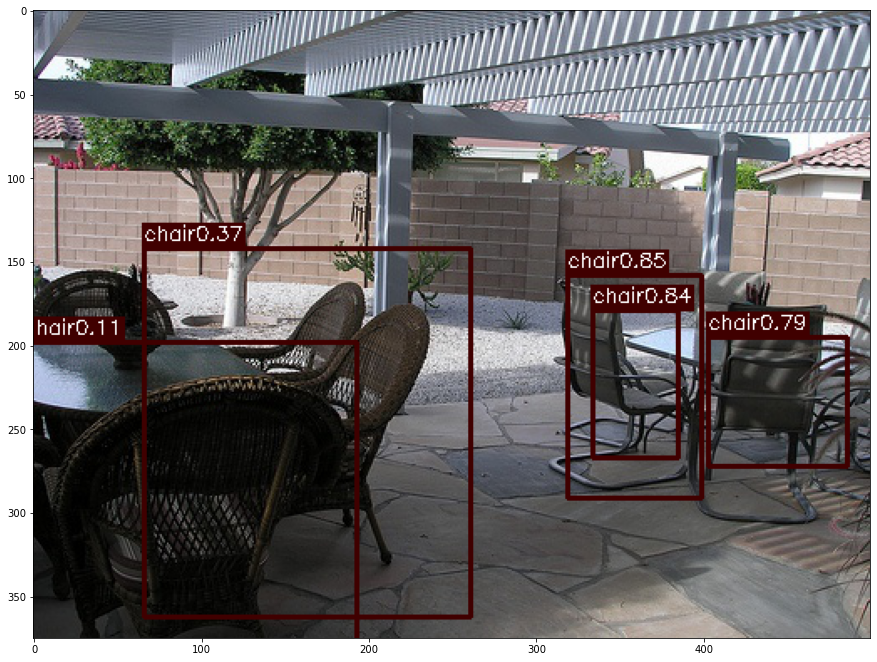

In [60]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
#print(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
#print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [11]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [05:46<00:00, 14.27it/s]


---class aeroplane ap 0.5101554725130132---
---class bicycle ap 0.6398618644394645---
---class bird ap 0.5735331616299372---
---class boat ap 0.279703331846731---
---class bottle ap 0.24641924017419142---
---class bus ap 0.6412772897078387---
---class car ap 0.6873356946550248---
---class cat ap 0.7455194814802607---
---class chair ap 0.33161524607104464---
---class cow ap 0.5914204944268717---
---class diningtable ap 0.40379706102911744---
---class dog ap 0.6646821193917353---
---class horse ap 0.6979302564479694---
---class motorbike ap 0.6087982382279886---
---class person ap 0.5661723100202078---
---class pottedplant ap 0.1987558817011582---
---class sheep ap 0.5460508513995598---
---class sofa ap 0.5129650197935819---
---class train ap 0.693917453560323---
---class tvmonitor ap 0.4901129829481896---
---map 0.5315011725732104---


In [12]:
output_submission_csv('my_solution.csv', test_aps)

In [80]:
#file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
file_root_test = 'newtests/'
print(file_root_test)
#file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

newtests/
Initializing dataset
Loaded 4950 test images


In [ ]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
#print(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)
